# Spatial Transcriptomics Analysis – Human Cerebellum (10x Visium)

**Goal:**  
Identify spatially coherent transcriptional domains and marker genes in human cerebellum using 10x Visium data.

**Key question:**  
Do gene expression patterns define biologically meaningful spatial regions in brain tissue?


In [2]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import os


c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


Load counts

In [3]:
adata = sc.read_10x_mtx(
    r"C:\Users\megha\Downloads\human_cerebellum_visium\filtered_feature_bc_matrix",
    var_names="gene_symbols",
    cache=False
)

adata


AnnData object with n_obs × n_vars = 4992 × 36601
    var: 'gene_ids', 'feature_types'

Attach spatial coordinates

In [4]:
positions = pd.read_csv(
    r"C:\Users\megha\Downloads\human_cerebellum_visium\spatial\tissue_positions_list.csv",
    header=None,
    index_col=0
)

positions.columns = [
    "in_tissue",
    "array_row",
    "array_col",
    "pxl_row_in_fullres",
    "pxl_col_in_fullres"
]

adata.obs = adata.obs.join(positions, how="left")

adata.obsm["spatial"] = adata.obs[
    ["pxl_row_in_fullres", "pxl_col_in_fullres"]
].to_numpy()


In [6]:

adata.write("human_cerebellum_spatial_raw.h5ad")


In [7]:
import scanpy as sc
adata = sc.read("human_cerebellum_spatial_raw.h5ad")


In [8]:
import scanpy as sc

adata = sc.read("human_cerebellum_spatial_raw.h5ad")
adata


AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

QC metrics

In [53]:
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    inplace=True
)


Spatial QC plot

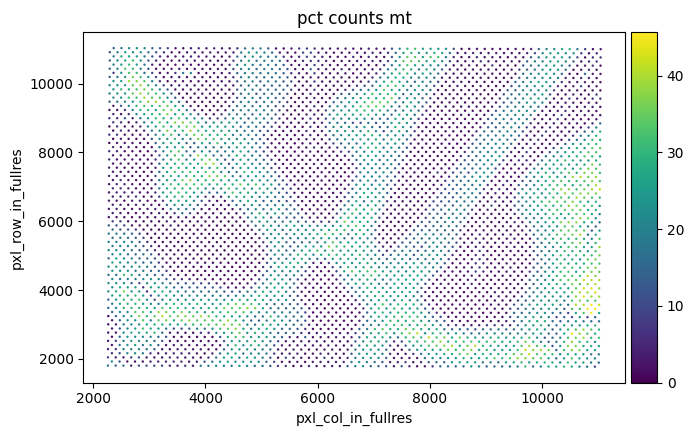

In [54]:
sc.pl.scatter(
    adata,
    x="pxl_col_in_fullres",
    y="pxl_row_in_fullres",
    color="pct_counts_mt",
    size=12
)


Apply QC filtering

In [55]:
adata_qc = adata[
    (adata.obs["pct_counts_mt"] < 30) &
    (adata.obs["n_genes_by_counts"] > 500) &
    (adata.obs["total_counts"] > 1000),
].copy()

adata_qc


AnnData object with n_obs × n_vars = 4068 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

Sanity check after filtering

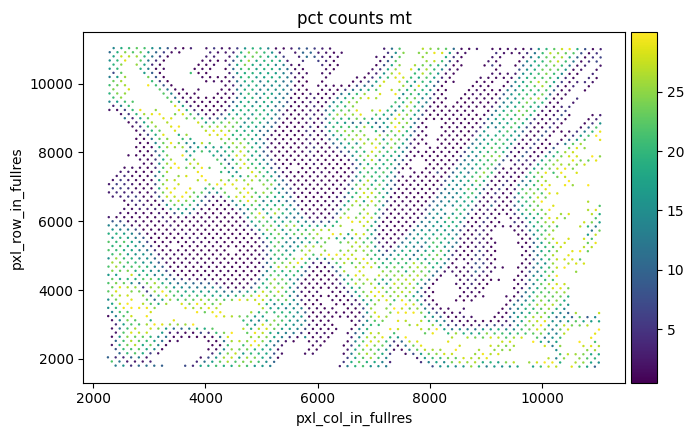

In [ ]:
sc.pl.scatter(
    adata_qc,
    x="pxl_col_in_fullres",
    y="pxl_row_in_fullres",
    color="pct_counts_mt",
    size=12
)
 

Normalize & log-transform

In [57]:
sc.pp.normalize_total(adata_qc, target_sum=1e4)
sc.pp.log1p(adata_qc)


Highly variable genes

In [58]:
sc.pp.highly_variable_genes(
    adata_qc,
    flavor="seurat",
    n_top_genes=3000
)
adata_qc = adata_qc[:, adata_qc.var.highly_variable]


Scale & PCA

In [59]:
sc.pp.scale(adata_qc, max_value=10)
sc.tl.pca(adata_qc, n_comps=50)


c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


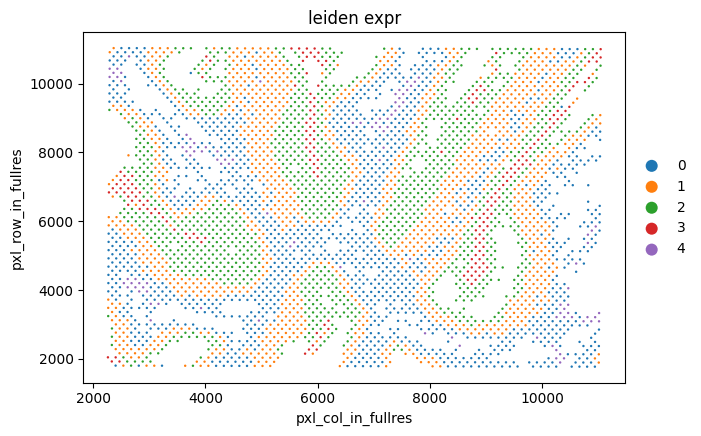

In [79]:
# Expression-only graph
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=30)

# Expression-only clustering
sc.tl.leiden(
    adata_qc,
    resolution=0.4,
    key_added="leiden_expr"
)

# Test spatial coherence (visualization only)
sc.pl.scatter(
    adata_qc,
    x="pxl_col_in_fullres",
    y="pxl_row_in_fullres",
    color="leiden_expr",
    size=12
)


 Spatially informed clustering (comparison analysis)

In [80]:
sq.gr.spatial_neighbors(adata_qc, coord_type="generic", spatial_key="spatial")

sc.tl.leiden(
    adata_qc,
    adjacency=adata_qc.obsp["spatial_connectivities"],
    key_added="leiden_spatial",
    resolution=0.4
)


In [81]:
adata_qc.obs.columns


Index(['in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres',
       'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_expr',
       'leiden_spatial'],
      dtype='object')

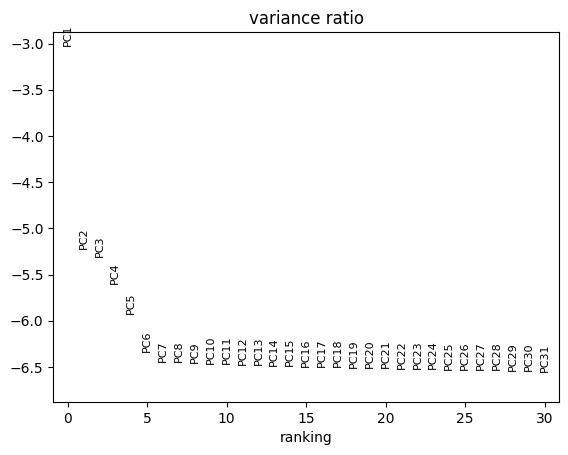

In [60]:
sc.pl.pca_variance_ratio(adata_qc, log=True)


c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\neighbors\__init__.py:577: UserWarning: You’re trying to run this on 36601 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


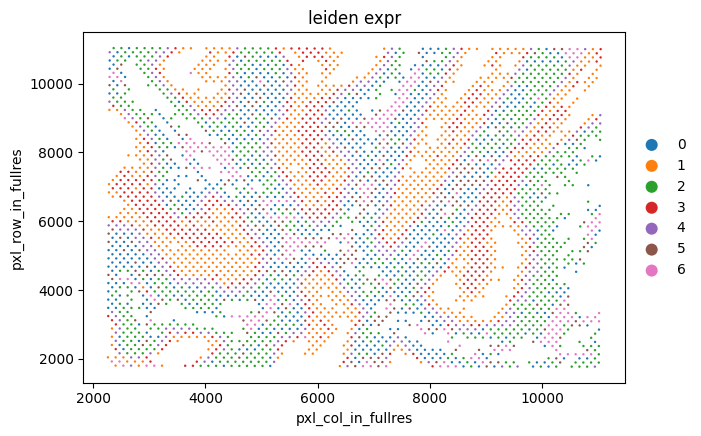

In [74]:
# Build expression-based neighborhood graph (gene expression ONLY)
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=30)

# Cluster based on expression graph
sc.tl.leiden(adata_qc, resolution=0.4, key_added="leiden_expr")

# Visualize clusters in spatial coordinates (ONLY visualization uses spatial)
sc.pl.scatter(
    adata_qc,
    x="pxl_col_in_fullres",
    y="pxl_row_in_fullres",
    color="leiden_expr",
    size=12
)


Spatial neighbors

In [63]:
import squidpy as sq

sq.gr.spatial_neighbors(
    adata_qc,
    coord_type="grid"
)


Tell Leiden to use the spatial graph

In [64]:
sc.tl.leiden(
    adata_qc,
    resolution=0.5,
    key_added="spatial_leiden",
    adjacency=adata_qc.obsp["spatial_connectivities"]
)


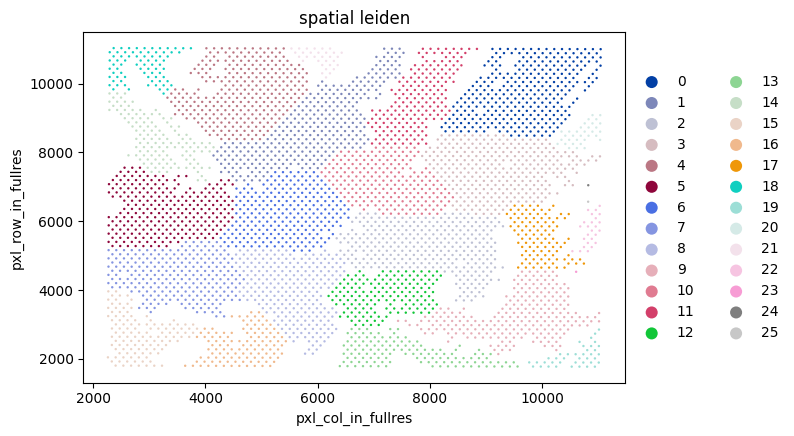

In [65]:
sc.pl.scatter(
    adata_qc,
    x="pxl_col_in_fullres",
    y="pxl_row_in_fullres",
    color="spatial_leiden",
    size=12
)


Marker genes per spatial cluster

In [67]:
adata_qc.obs["spatial_leiden"].value_counts()


spatial_leiden
0     310
1     308
2     299
3     295
4     292
5     254
6     246
7     245
8     243
9     233
10    212
11    178
12    151
13    128
14    126
15    121
16    116
17    104
18     76
19     39
20     33
21     31
22     25
23      1
24      1
25      1
Name: count, dtype: int64

In [68]:
valid_clusters = (
    adata_qc.obs["spatial_leiden"]
    .value_counts()
    .loc[lambda x: x >= 10]
    .index
)

valid_clusters


CategoricalIndex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
                  '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
                  '22'],
                 categories=['0', '1', '2', '3', ..., '22', '23', '24', '25'], ordered=False, dtype='category', name='spatial_leiden')

In [69]:
adata_qc_de = adata_qc[
    adata_qc.obs["spatial_leiden"].isin(valid_clusters)
].copy()


c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: inv

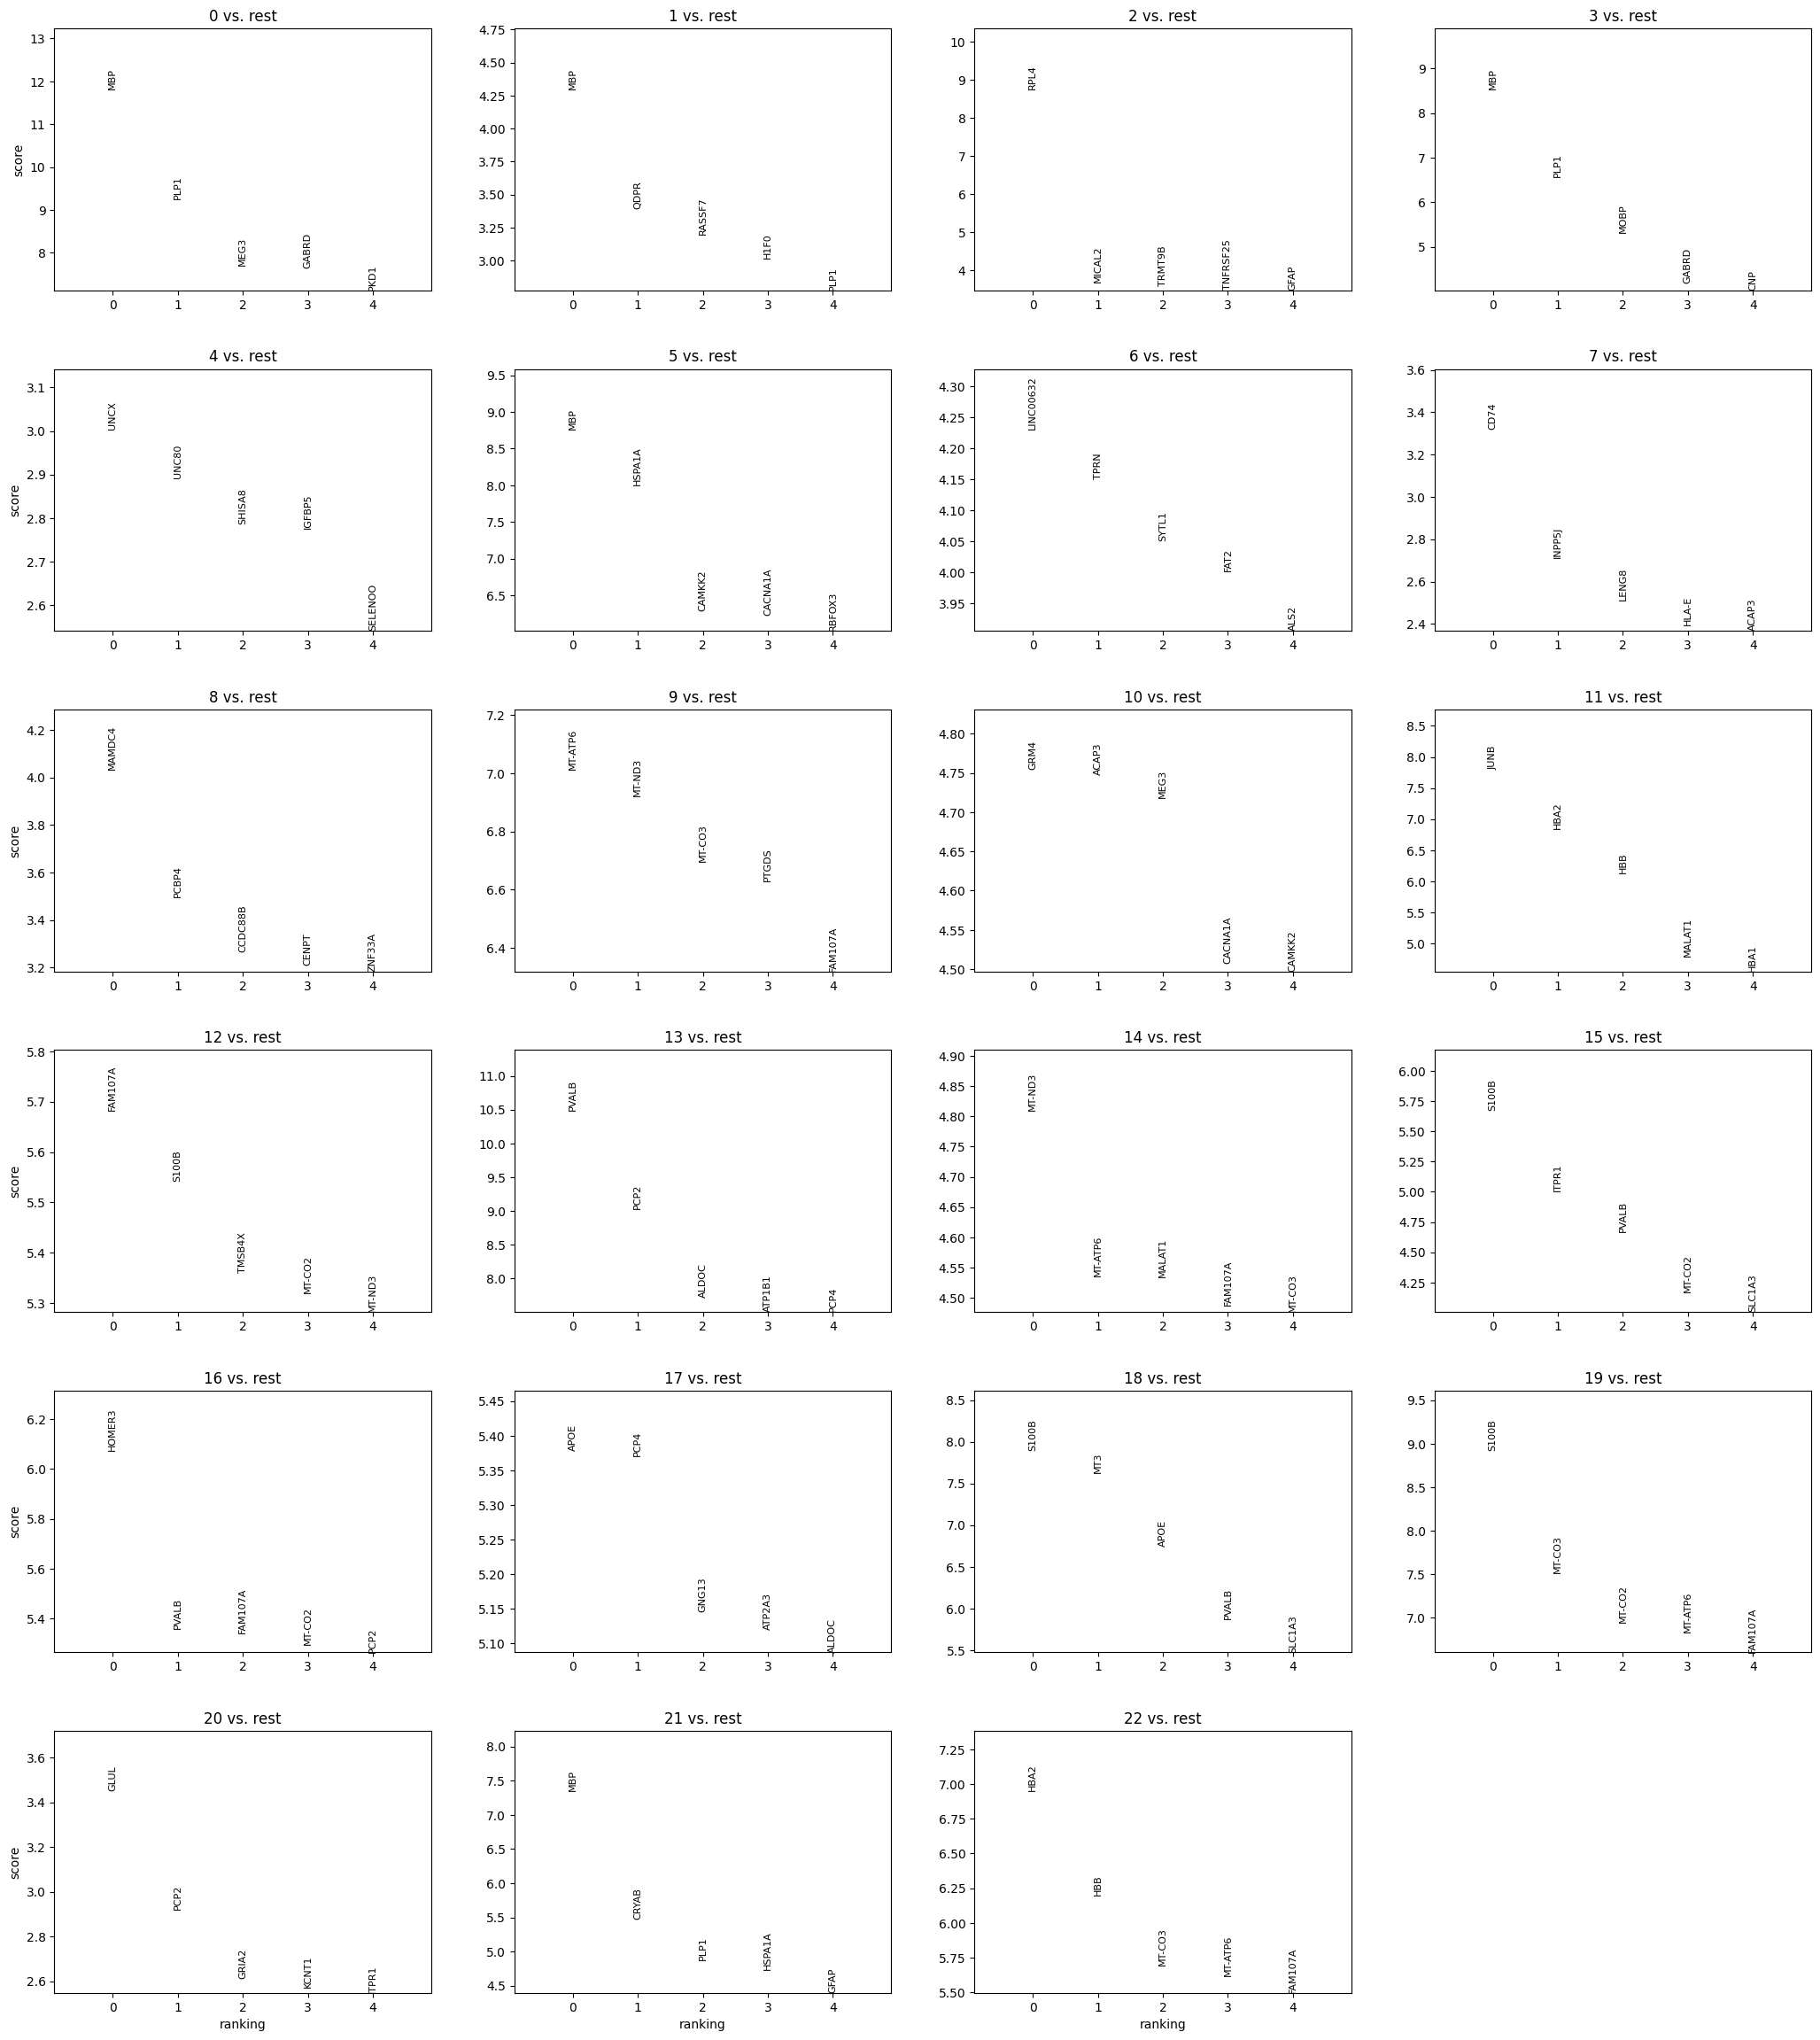

In [70]:
sc.tl.rank_genes_groups(
    adata_qc_de,
    groupby="spatial_leiden",
    method="wilcoxon"
)

sc.pl.rank_genes_groups(
    adata_qc_de,
    n_genes=5,
    sharey=False
)


In [71]:
sc.tl.leiden(
    adata_qc,
    resolution=0.3,
    key_added="spatial_leiden_r03",
    adjacency=adata_qc.obsp["spatial_connectivities"]
)


Apply QC filtering

In [72]:
adata_qc = adata[
    (adata.obs["pct_counts_mt"] < 30) &
    (adata.obs["n_genes_by_counts"] > 500) &
    (adata.obs["total_counts"] > 1000),
].copy()

adata_qc


AnnData object with n_obs × n_vars = 4068 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

Sanity check after filtering

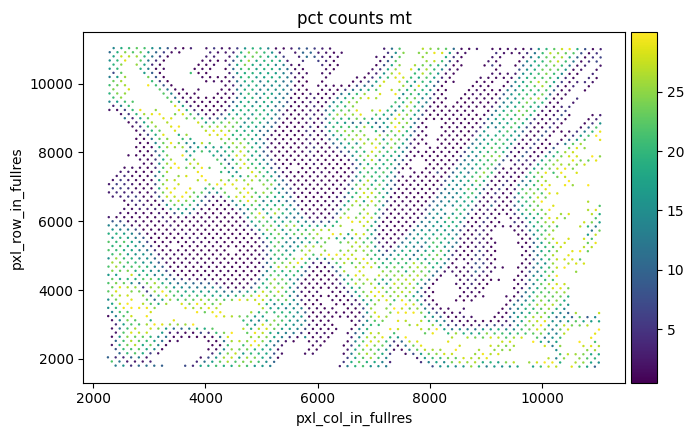

In [73]:
sc.pl.scatter(
    adata_qc,
    x="pxl_col_in_fullres",
    y="pxl_row_in_fullres",
    color="pct_counts_mt",
    size=12
)


In [75]:
sc.pp.normalize_total(adata_qc, target_sum=1e4)
sc.pp.log1p(adata_qc)
adata_qc.raw = adata_qc
sc.pp.highly_variable_genes(adata_qc, n_top_genes=2000, flavor="seurat")
adata_qc = adata_qc[:, adata_qc.var.highly_variable].copy()
sc.pp.scale(adata_qc, max_value=10)
sc.tl.pca(adata_qc, n_comps=50)


c:\Users\megha\AppData\Local\Programs\Python\Python310\lib\functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Expression-only clustering

In [76]:
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=30)
sc.tl.leiden(adata_qc, resolution=0.4, key_added="leiden_expr")


Plot in spatial coords

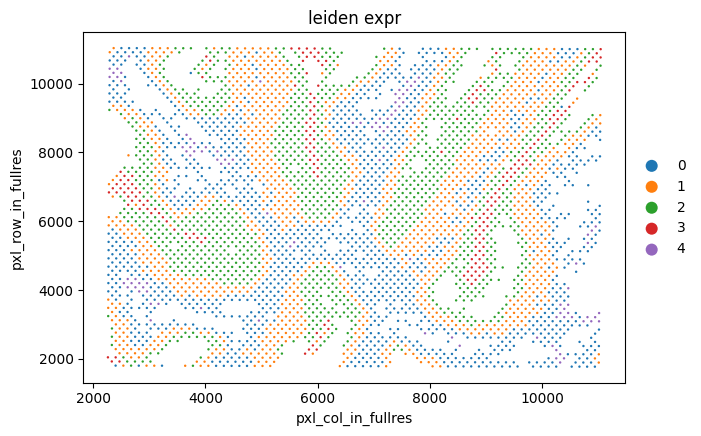

In [77]:
sc.pl.scatter(adata_qc, x="pxl_col_in_fullres", y="pxl_row_in_fullres",
              color="leiden_expr", size=12)


Marker genes

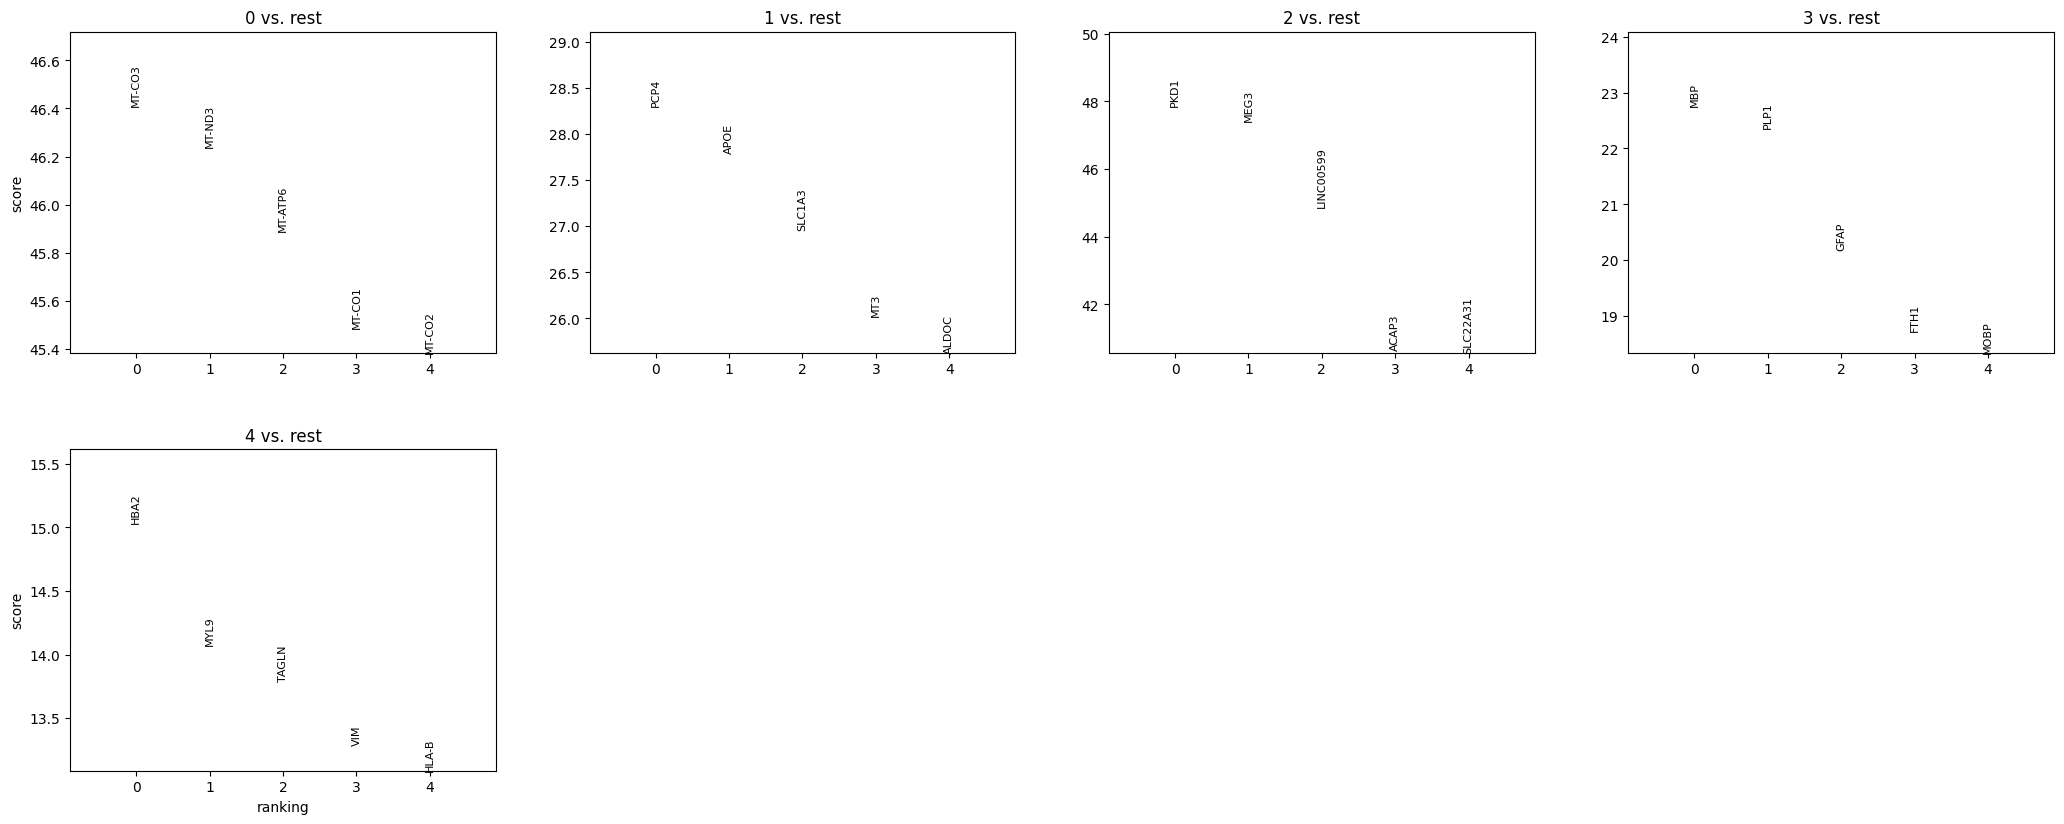

In [78]:
sc.tl.rank_genes_groups(adata_qc, groupby="leiden_expr", method="wilcoxon")
sc.pl.rank_genes_groups(adata_qc, n_genes=5, sharey=False)
